In [55]:
"""
Credits: https://pytorch.org/vision/main/auto_examples/plot_optical_flow.html?highlight=optical+flow

"""


import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision.transforms.functional as F

In [56]:
filename = "edition25_sequence_5.mp4"

DATA_PATH = './lausanne_prix/'
OUTPUT_PATH = './Result_OpticalFlow/'

In [57]:
video_input = DATA_PATH + filename
video_name = os.path.basename(video_input)

video_output = OUTPUT_PATH + video_name

In [58]:
plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

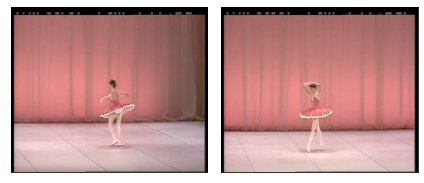

In [70]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_input), output_format="TCHW")

img1_batch = torch.stack([frames[500], frames[550]])
img2_batch = torch.stack([frames[501], frames[551]])

plot(img1_batch)

In [71]:
from torchvision.models.optical_flow import Raft_Small_Weights

weights = Raft_Small_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    #img1_batch = F.resize(img1_batch, size=[608, 720])
    #img2_batch = F.resize(img2_batch, size=[608, 720])
    return transforms(img1_batch, img2_batch)


print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 608, 720]), dtype = torch.uint8
shape = torch.Size([2, 3, 608, 720]), dtype = torch.float32


In [72]:
from torchvision.models.optical_flow import raft_small

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [73]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 608, 720]) = (N, 2, H, W)
min = -17.800172805786133, max = 44.04299545288086


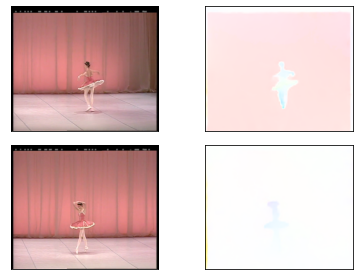

In [74]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [75]:
###############################################################
# def vizualize_flow(img, flo, save, counter):
#     # convert CWH to WHC format and change device if necessary  
#     img = img[0].permute(1, 2, 0).cpu().numpy()
#     flo = flo[0].permute(1, 2, 0).cpu().numpy()
 
#     # map flow to rgb image
#     flo = flow_viz.flow_to_image(flo)
#     flo = cv2.cvtColor(flo, cv2.COLOR_RGB2BGR)
 
#     # concatenate, save and show images
#     img_flo = np.concatenate([img, flo], axis=0)
#     if save:
#         cv2.imwrite(f"demo_frames/frame_{str(counter)}.jpg", img_flo)
#     cv2.imshow("Optical Flow", img_flo / 255.0)
 
#     k = cv2.waitKey(25) & 0xFF
#     if k == 27:
#         return False
#     return True

In [ ]:
cap = cv2.VideoCapture(video_input)

# Obtain frame size information using get() method
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_size = (frame_width,frame_height)
fps = int(cap.get(cv2.CAP_PROP_FPS))

cap.release()

# Initialize video writer object
output = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

count = 0
for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    img1 = torch.stack([img1])
    img2 = torch.stack([img2])
    #img1 = np.expand_dims(img1, axis=0)
    #img2 = np.expand_dims(img2, axis=0)
    #print(f"shape = {img1.shape}, dtype = {img1.dtype}")
    img1, img2 = preprocess(img1, img2)
    #print(img1.shape)
    #print(img2.shape)
    list_of_flows = model(img1.to(device), img2.to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    #print(f"shape = {flow_img.shape}, dtype = {flow_img.dtype}")
    flow_img = flow_img.numpy()
    #print(f"shape = {flow_img.shape}, dtype = {flow_img.dtype}")
    output.write(flow_img)
    
    #print(count)
    count += 1
output.release()        